In [1]:
import pandas as pd
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from pyomo.environ import *
import pyomo.environ as pe
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np


In [2]:
def silu_fn(z):
    
    return z / (1 + np.exp(-z))
dtype = torch.get_default_dtype()

In [3]:
df = pd.read_csv('data.csv', header=1)
X = df.drop(columns=['thr','te','power'])
scaler_input = MinMaxScaler()
train_input_scaled = scaler_input.fit_transform(X)


In [4]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, activation_fn=nn.ReLU, activation_scale=1.0):
        super(Net, self).__init__()
        self.hidden = nn.Linear(n_feature, n_hidden)   
        self.predict = nn.Linear(n_hidden, n_output)   
        self.activation_fn = activation_fn()           
        

    def forward(self, x):
        x = self.activation_fn(self.hidden(x))  
        x = self.predict(x)                                             
        return x

# THR Model

In [5]:
checkpoint = torch.load(f"thr_ext_model.pth")
params1 = checkpoint['params']
model_lower = Net(
    n_feature=9,
    n_hidden=10,
    n_output=1,
    activation_fn=nn.SiLU,)
model_lower.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [6]:
state_dict_lower = model_lower.state_dict()
W1_lower = state_dict_lower['hidden.weight'].numpy()
b1_lower = state_dict_lower['hidden.bias'].numpy()
W2_lower = state_dict_lower['predict.weight'].numpy()
b2_lower = state_dict_lower['predict.bias'].numpy()

# Power Model

In [7]:
checkpoint = torch.load(f"power_ext_model.pth")
params1 = checkpoint['params']
model_upper = Net(
    n_feature=9,
    n_hidden=31,
    n_output=1,
    activation_fn=nn.SiLU
    )
model_upper.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [8]:
state_dict_upper = model_upper.state_dict()
W1_upper = state_dict_upper['hidden.weight'].numpy()
b1_upper = state_dict_upper['hidden.bias'].numpy()
W2_upper = state_dict_upper['predict.weight'].numpy()
b2_upper = state_dict_upper['predict.bias'].numpy()

In [45]:
train_input_scaled_df=pd.DataFrame(train_input_scaled, columns=X.columns)

# Thermal Efficiency

In [9]:
checkpoint = torch.load(f"te_ext_model.pth")
params1 = checkpoint['params']
model_te = Net(
    n_feature=9,
    n_hidden=22,
    n_output=1,
    activation_fn=nn.SiLU
    )
model_te.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [10]:
state_dict_te = model_te.state_dict()
W1_te = state_dict_te['hidden.weight'].numpy()
b1_te = state_dict_te['hidden.bias'].numpy()
W2_te = state_dict_te['predict.weight'].numpy()
b2_te = state_dict_te['predict.bias'].numpy()

In [48]:
pd.DataFrame(train_input_scaled, columns=X.columns)

,cdp,gffr,fgt,at,ap,ah,phgot,cdt,fgext
0,0.483485,0.510675,0.510511,0.380845,0.676741,0.752338,0.657962,0.363868,0.793780
1,0.468376,0.548053,0.588242,0.400958,0.684187,0.741559,0.427813,0.351192,0.816933
2,0.488951,0.572813,0.591472,0.381426,0.744306,0.750910,0.137413,0.389613,0.886413
3,0.160401,0.183482,0.767659,0.430221,0.796978,0.702303,0.451135,0.169066,0.932741
4,0.149450,0.199031,0.753829,0.417441,0.691743,0.726842,0.564557,0.141682,0.932741
...,...,...,...,...,...,...,...,...,...
485,0.270590,0.344896,0.743605,0.250436,0.721748,0.564406,0.415818,0.205054,0.991321
486,0.269046,0.351056,0.773643,0.215074,0.759417,0.609655,0.465883,0.200233,0.991321
487,0.262765,0.346630,0.672056,0.222408,0.766864,0.580331,0.444016,0.196096,0.991321
488,0.269843,0.338855,0.758624,0.221173,0.759417,0.612997,0.478153,0.205555,0.991321


# Model Definition 

In [49]:
model = ConcreteModel()
lower_bounds = [0.0,0.0,0.0,  0.425, 0.595, 0.495, 0.0,0.0,0.0]  # Lower bounds for indices 0, 1, 2
upper_bounds = [ 1.8, 1.8, 1.8,  0.430, 0.61, 0.505, 1.8, 1.8, 1.8]   # Upper bounds for indices 0, 1, 2

def variable_bounds(model, i):
    return (lower_bounds[i], upper_bounds[i])

model.x = Var(RangeSet(0, train_input_scaled.shape[1]-1), bounds=variable_bounds)



In [50]:
def mahalanobis_constraint(train_input_scaled,tolerance, factor = 1):
    mu = np.mean(train_input_scaled, axis=0)
    cov = np.cov(train_input_scaled, rowvar=False)
    inv_cov = np.linalg.pinv(cov)
    centered_data = train_input_scaled - mu
    D_M = np.sqrt(np.einsum('...i,ij,...j->...', centered_data, inv_cov, centered_data))
    return mu, inv_cov, np.percentile(D_M, tolerance) * factor

In [51]:
def add_upper_mahalanobis_constraint(model, train_input_scaled, tolerance, factor):
    mu, inv_cov, delta=mahalanobis_constraint(train_input_scaled, tolerance,factor)

    centered = [model.x[index] - mu[index] for index in range(train_input_scaled.shape[1])]

    quadratic_form = sum(centered[i] * inv_cov[i,j] * centered[j] for i in range(train_input_scaled.shape[1]) for j in range(train_input_scaled.shape[1]))
    
    setattr(model,'mahalanobis_constraint',Constraint(rule=delta-quadratic_form**0.5  >= 0))

In [52]:
def thr(model):
    total = b2_lower[0]
    for j in range(W1_lower.shape[0]):
        sum_in = b1_lower[j]
        for i in range(W1_lower.shape[1]):
            sum_in += W1_lower[j, i] * model.x[i]
        activated = sum_in / (1 + pe.exp(-sum_in))
        total += W2_lower[0, j] * activated
    return total

In [53]:
def power(model):
    total = b2_upper[0]
    for j in range(W1_upper.shape[0]):
        sum_in = b1_upper[j]
        for i in range(W1_upper.shape[1]):
            sum_in += W1_upper[j, i] * model.x[i]
        activated = sum_in / (1 + pe.exp(-sum_in))
        total += W2_upper[0, j] * activated
    return total 

In [54]:
def te(model):
    total = b2_te[0]
    for j in range(W1_te.shape[0]):
        sum_in = b1_te[j]
        for i in range(W1_te.shape[1]):
            sum_in += W1_te[j, i] * model.x[i]
        activated = sum_in / (1 + pe.exp(-sum_in))
        total += W2_te[0, j] * activated
    return total 

In [55]:
tolerance =60 # 40 for 385 MW, 45 for 390 MW AND 60 for 395 MW
factor = 1.0
add_upper_mahalanobis_constraint(model, train_input_scaled, tolerance, factor)

# Set Value of Power

In [56]:
scaler_input1 = MinMaxScaler()
train_label_scaled = scaler_input1.fit_transform(df['power'].values.reshape(-1, 1))
scaler_input2 = MinMaxScaler()
train_label_scaled = scaler_input2.fit_transform(df['thr'].values.reshape(-1, 1))
scaler_input3 = MinMaxScaler()
train_label_scaled = scaler_input3.fit_transform(df['te'].values.reshape(-1, 1))

In [57]:
current_value = 395
current_value_s = scaler_input1.transform([[current_value]])[0][0]
current_value

395

In [58]:
def power_constraint (model): return (power(model)-current_value_s)**2 == 1e-10

model.power_constraint = Constraint(rule=power_constraint)

In [59]:
def objectives(model):
    thr_value = thr(model)
    te_value = te(model)
    #return (power(model)-current_value_s)**2 
    return (thr_value) - (te_value)
model.objectives = Objective(expr=objectives, sense=minimize)

In [60]:
solver = SolverFactory('gams:SNOPT')
#}

In [61]:
val=pd.read_csv('val.csv',header=1)
extra_1=pd.read_csv('extra.csv')
extra = pd.concat([val, extra_1],axis=0)
val_1=extra.drop(columns=['thr','te','power'])
vals=scaler_input.transform(val_1)

In [62]:
best_values = []
thr_sol = []
power_sol = []
TE_sol=[]

for x0 in vals[:50]:
    initial_values = list(np.clip(x0, 0, 1))
    for i in range(x0.shape[0]):
        model.x[i] = initial_values[i]

    results = solver.solve(model, tee=  True)

    optimal_scaled = [model.x[i]() for i in range(x0.shape[0])]
    optimal_real = scaler_input.inverse_transform([optimal_scaled])[0]
    best_values.append(optimal_real)
    thr_sol.append(thr(model)())
    power_sol.append(power(model)())
    TE_sol.append(te(model)())

WARNING (W1002): Setting Var 'x[3]' to a numeric value `0.3655968632006972`
outside the bounds (0.425, 0.43).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'x[4]' to a numeric value `0.8195356986421274`
outside the bounds (0.595, 0.61).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'x[5]' to a numeric value `0.771008535207732`
outside the bounds (0.495, 0.505).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
--- Job model.gms Start 06/25/25 14:54:53 38.2.1 96226ea8 WEX-WEI x86 64bit/MS Windows
--- Applying:
    C:\GAMS\38\gmsprmNT.txt
    C:\Users\Waqar\OneDrive - University College London\Documents\GAMS\gamsconfig.yaml
--- GAMS Parameters defined
    Input C:\Users\Waqar\AppData\Local\Temp\tmp8kolog4k\model.gms
    Output C:\Users\Waqar\AppData\Local\Temp\tmp8kolog4k\output.lst
    ScrDir C:\Users\Waqar\AppData\Local\Temp\tmp8kolog4k\225a\
    SysDir C:\GAMS\

In [63]:
scaled_value_power = power(model)()
original_value_power = scaler_input1.inverse_transform([[scaled_value_power]])[0][0]
scaled_value_thr = thr(model)()
original_value_thr = scaler_input2.inverse_transform([[scaled_value_thr]])[0][0]
scaled_value_te = te(model)()
original_value_te = scaler_input3.inverse_transform([[scaled_value_te]])[0][0]
print(f"Power: {original_value_power:.3f} MW  || Thr: {original_value_thr:.0f} kJ/kWh || Te: {original_value_te:.2f} %")

Power: 394.998 MW  || Thr: 8509 kJ/kWh || Te: 42.91 %


In [65]:
columns=['cdp', 'gffr', 'fgt', 'at', 'ap', 'ah', 'phgot', 'cdt', 'fgext']
best_values = pd.DataFrame(best_values,columns=columns)
best_values['Power_sol'] = original_value_power
best_values['THR_sol'] = original_value_thr
best_values['TE_sol'] = original_value_te

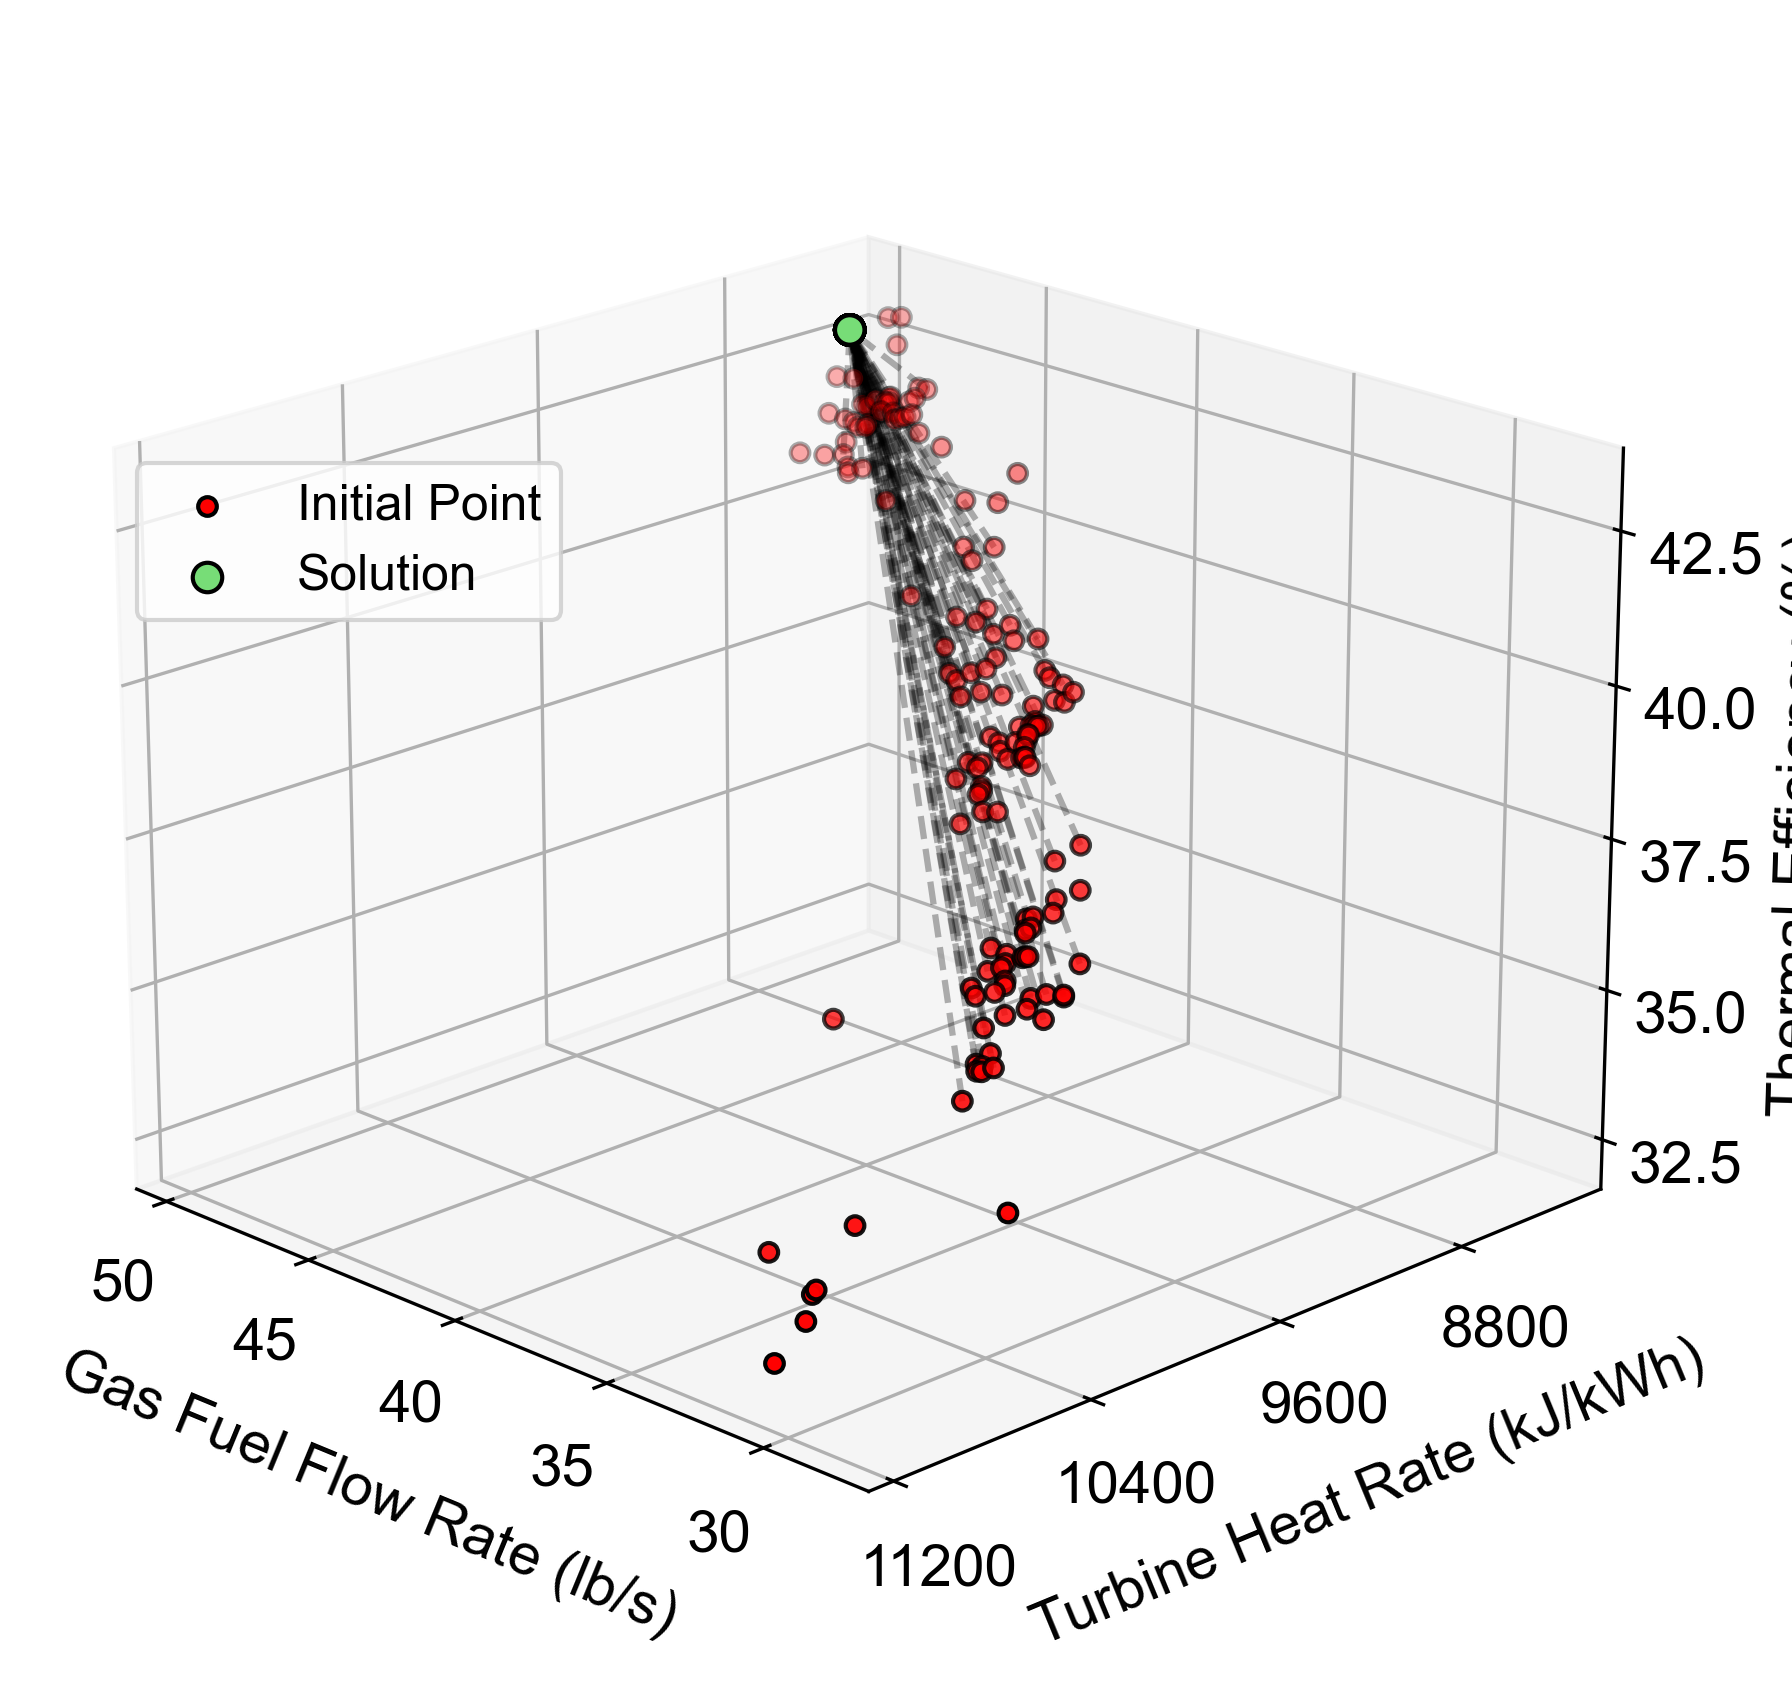

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Configuration variables
fig_size = (7, 7)  # Increased figure size
fig_dpi = 300

# Update global font properties
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 14,  # Increased font size
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})

# Create 3D figure with more space for labels
fig = plt.figure(figsize=fig_size, dpi=fig_dpi)
ax = fig.add_subplot(111, projection='3d')

# Plot initial points (red)
ax.scatter(val['gffr'].values, 
          val['thr'].values, 
          val['te'].values, 
          color='red', edgecolor='black', 
          label='Initial Point', s=20)  # Increased marker size

# Plot solution points (green)
ax.scatter(best_values['gffr'].values, 
          best_values['THR_sol'].values, 
          best_values['TE_sol'].values, 
          color='#77DD77', edgecolor='black', 
          label='Solution', s=50)  # Increased marker size

# Connect points with lines
for n in range(len(best_values)):
    ax.plot([val['gffr'].values[n], best_values['gffr'].values[n]], 
            [val['thr'].values[n], best_values['THR_sol'].values[n]],
            [val['te'].values[n], best_values['TE_sol'].values[n]], 
            linestyle='--', alpha=0.3, color='black')  # Increased line opacity

# Set labels with increased padding
ax.set_xlabel('Gas Fuel Flow Rate (lb/s)', labelpad=10)
ax.set_ylabel('Turbine Heat Rate (kJ/kWh)', labelpad=10)
ax.set_zlabel('Thermal Efficiency (%)', labelpad=5)

# Adjust viewing angle for better visibility of all axes
ax.view_init(elev=20, azim=135)  # Modified viewing angle

# Add legend inside the plot
ax.legend(loc='upper left', bbox_to_anchor=(0.05, 0.75), fontsize=12)

# Adjust axis limits to add spacing
x_min, x_max = val['gffr'].min(), best_values['gffr'].max()
x_margin = (x_max - x_min) * 0.1  # 10% margin
ax.set_xlim(x_min - x_margin, x_max + x_margin)

# Adjust spacing between ticks
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.zaxis.set_major_locator(plt.MaxNLocator(5))

# Adjust layout
plt.tight_layout(pad=4.0)  # Increased padding

# Save and show plot
plt.savefig('3d_scatter Solution Convergence.png', bbox_inches='tight', pad_inches=0.5)  # Added padding to saved figure
plt.show()

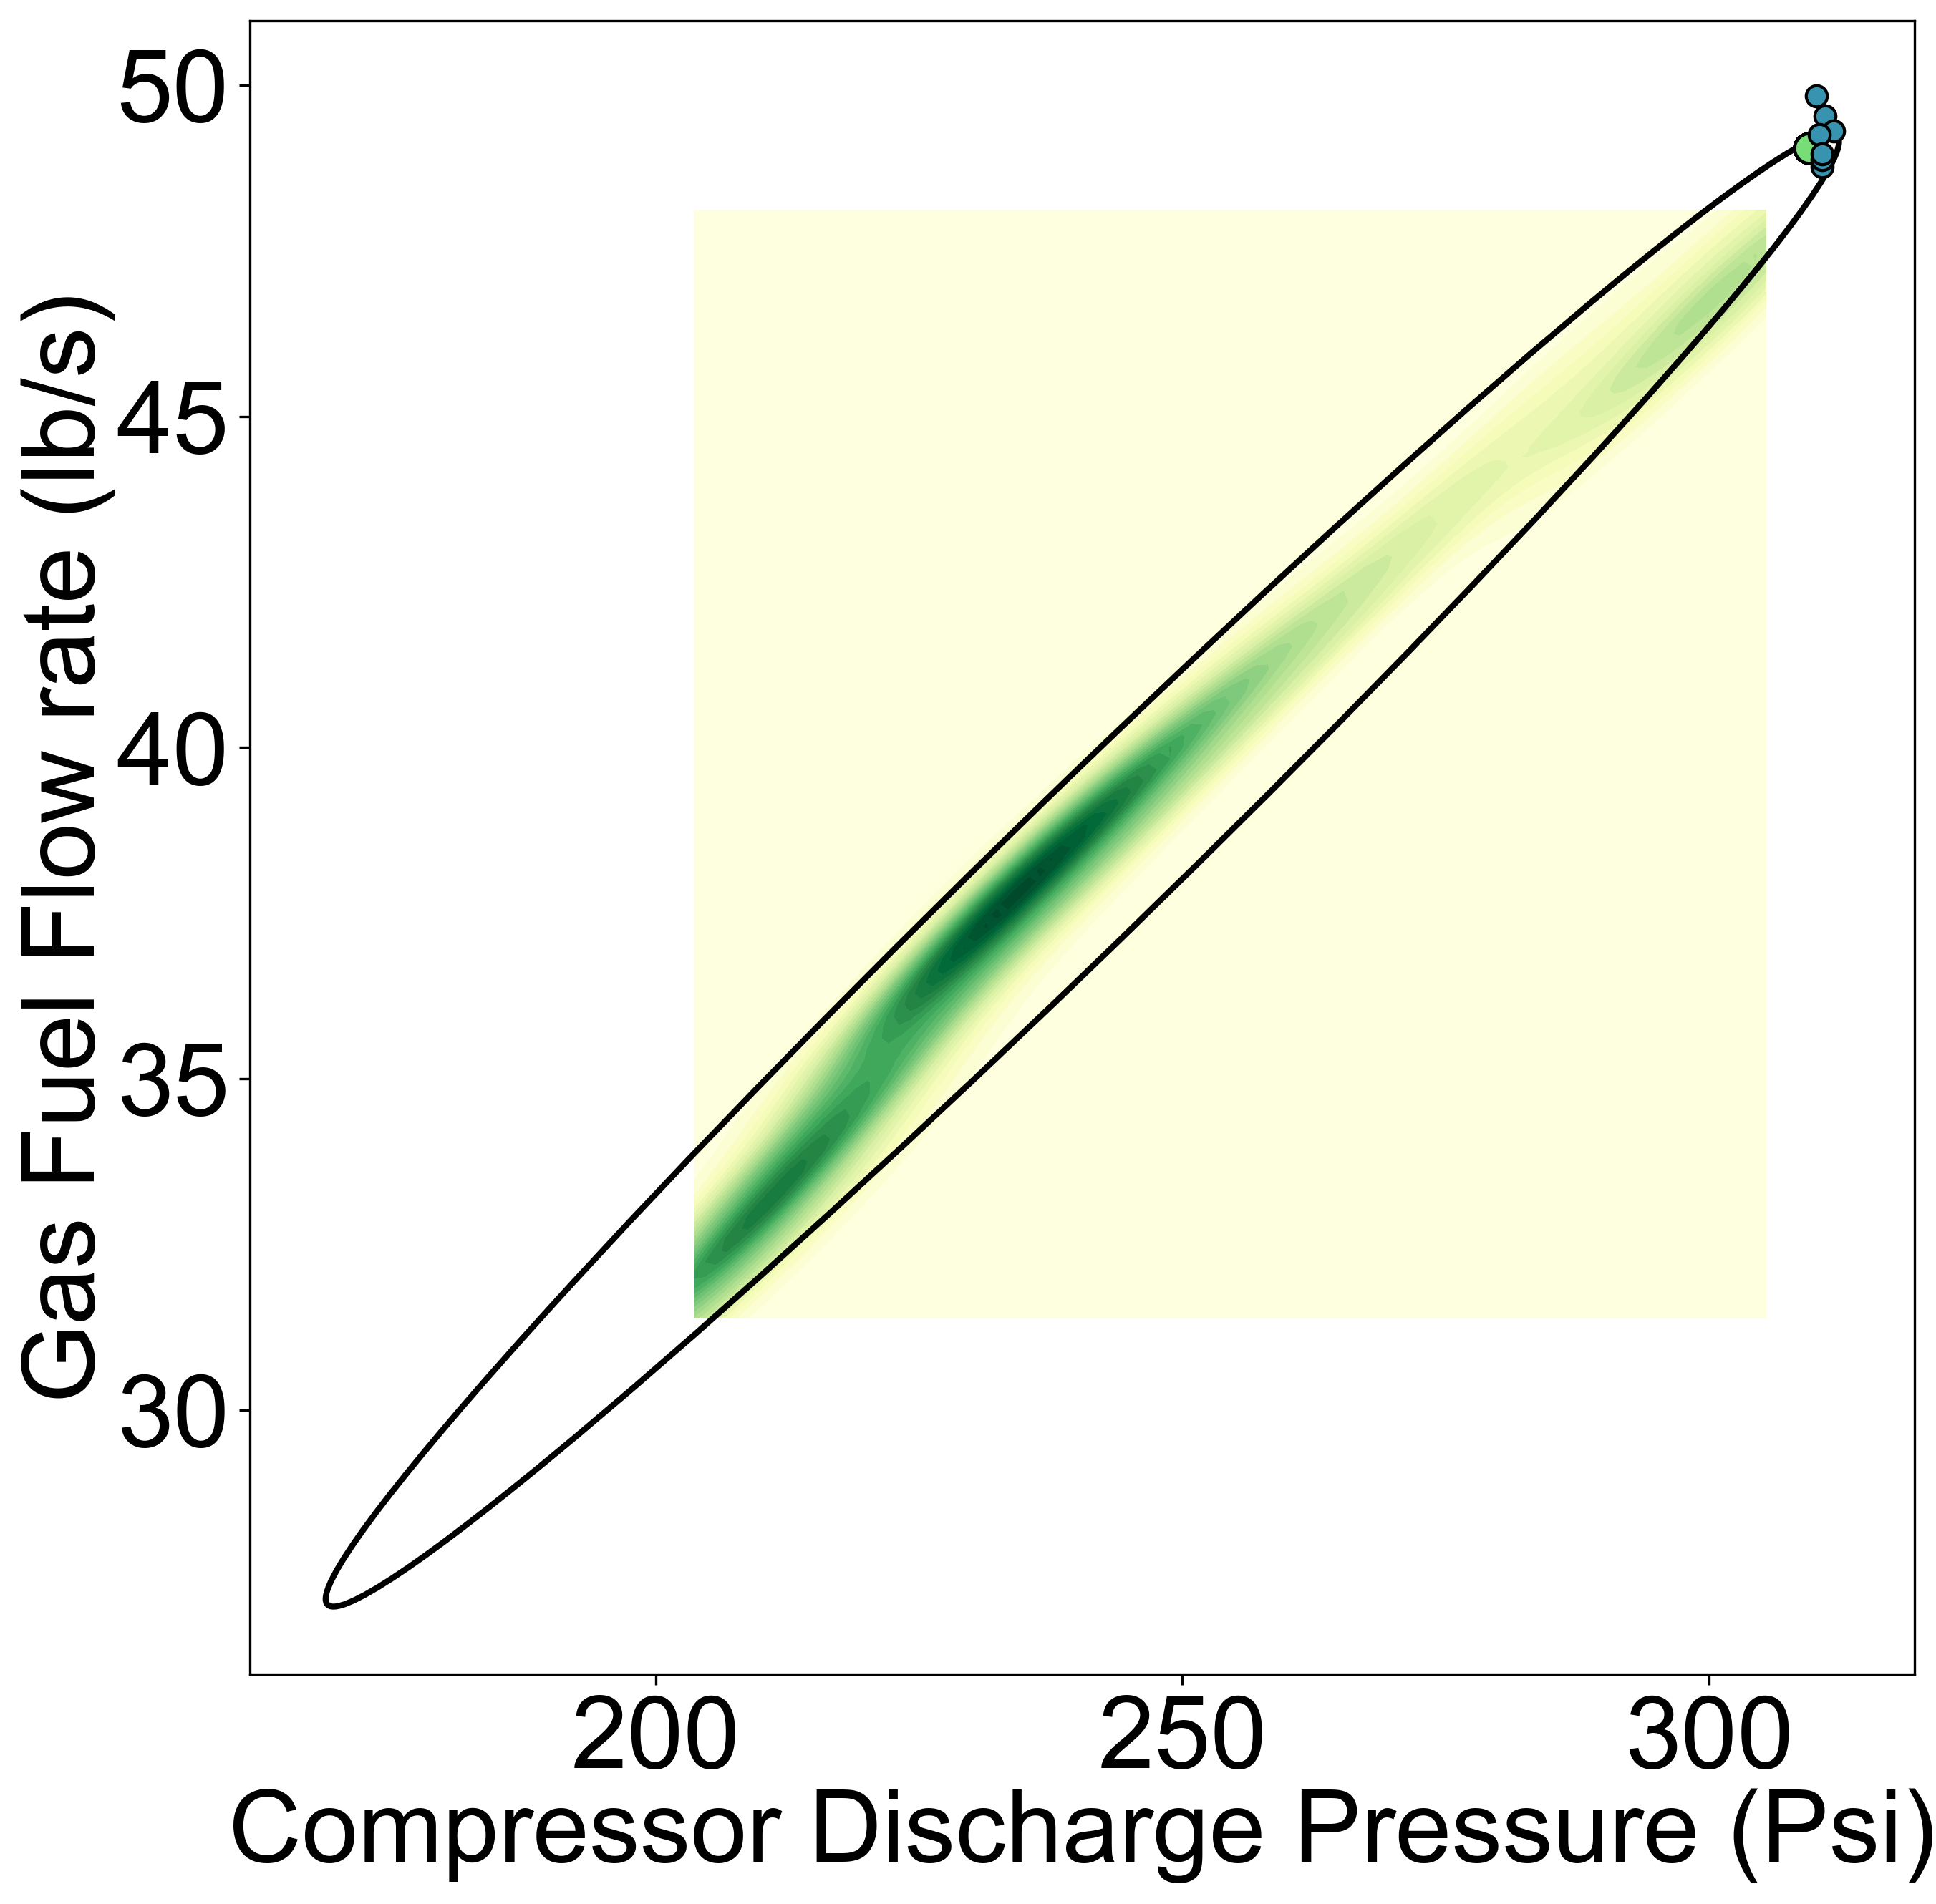

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import gaussian_kde
import pandas as pd

# -------------------------------
# Configuration variables
# -------------------------------
feature_x = 'cdp'
feature_y = 'gffr'
color_map = 'YlGn'
grid_resolution = 100
fig_size = (10, 10)
fig_dpi = 300
ellipse_style = {
    'edgecolor': 'black', 
    'linestyle': '-', 
    'linewidth': 2, 
    'facecolor': 'None',
    'alpha': 1
}
tolerance = 0.95  # 95% coverage
factor = 1.0
# -------------------------------

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 18,
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})

X = df[[feature_x, feature_y]].values

mu = np.mean(X, axis=0)
cov = np.cov(X, rowvar=False)
inv_cov = np.linalg.pinv(cov)

centered_data = X - mu
D_M = np.sqrt(np.einsum('...i,ij,...j->...', centered_data, inv_cov, centered_data))
delta = np.percentile(D_M, tolerance * 100) * factor  # <-- FIXED LINE

eigenvals, eigenvecs = np.linalg.eigh(cov)
order = eigenvals.argsort()[::-1]
eigenvals = eigenvals[order]
eigenvecs = eigenvecs[:, order]

angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
width = 2 * delta * np.sqrt(eigenvals[0])
height = 2 * delta * np.sqrt(eigenvals[1])

x = df[feature_x].values
y = df[feature_y].values

kde = gaussian_kde(np.vstack([x, y]))

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
xgrid = np.linspace(xmin, xmax, grid_resolution)
ygrid = np.linspace(ymin, ymax, grid_resolution)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde(np.vstack([Xgrid.ravel(), Ygrid.ravel()])).reshape(Xgrid.shape)

fig, ax = plt.subplots(figsize=fig_size, dpi=fig_dpi)
cb = ax.contourf(Xgrid, Ygrid, Z, levels=25, cmap=color_map)

ellipse = Ellipse(mu, width, height, angle=angle, **ellipse_style)
ax.add_patch(ellipse)

ax.scatter(best_values[feature_x], best_values[feature_y], 
           color='#77DD77', edgecolor='black', s=100, label='Optimal Solution')

ax.scatter(
    extra[(extra['power'] < current_value + 1) & (extra['power'] > current_value - 1)][feature_x],
    extra[(extra['power'] < current_value + 1) & (extra['power'] > current_value - 1)][feature_y], 
    color="#3793AF", edgecolor='black', s=50, label='Experimental'
)

ax.set_xlabel('Compressor Discharge Pressure (Psi)', labelpad=0, fontsize=34)
ax.set_ylabel('Gas Fuel Flow rate (lb/s)', labelpad=0, fontsize=34)
ax.tick_params(axis='both', which='major', labelsize=34)  # Increase tick font size
#ax.legend(loc='upper left', fontsize=34)  # Increase legend font size

plt.savefig(f'correlated_fig_{current_value}_{tolerance}.png', bbox_inches='tight', pad_inches=0.3)
plt.show()

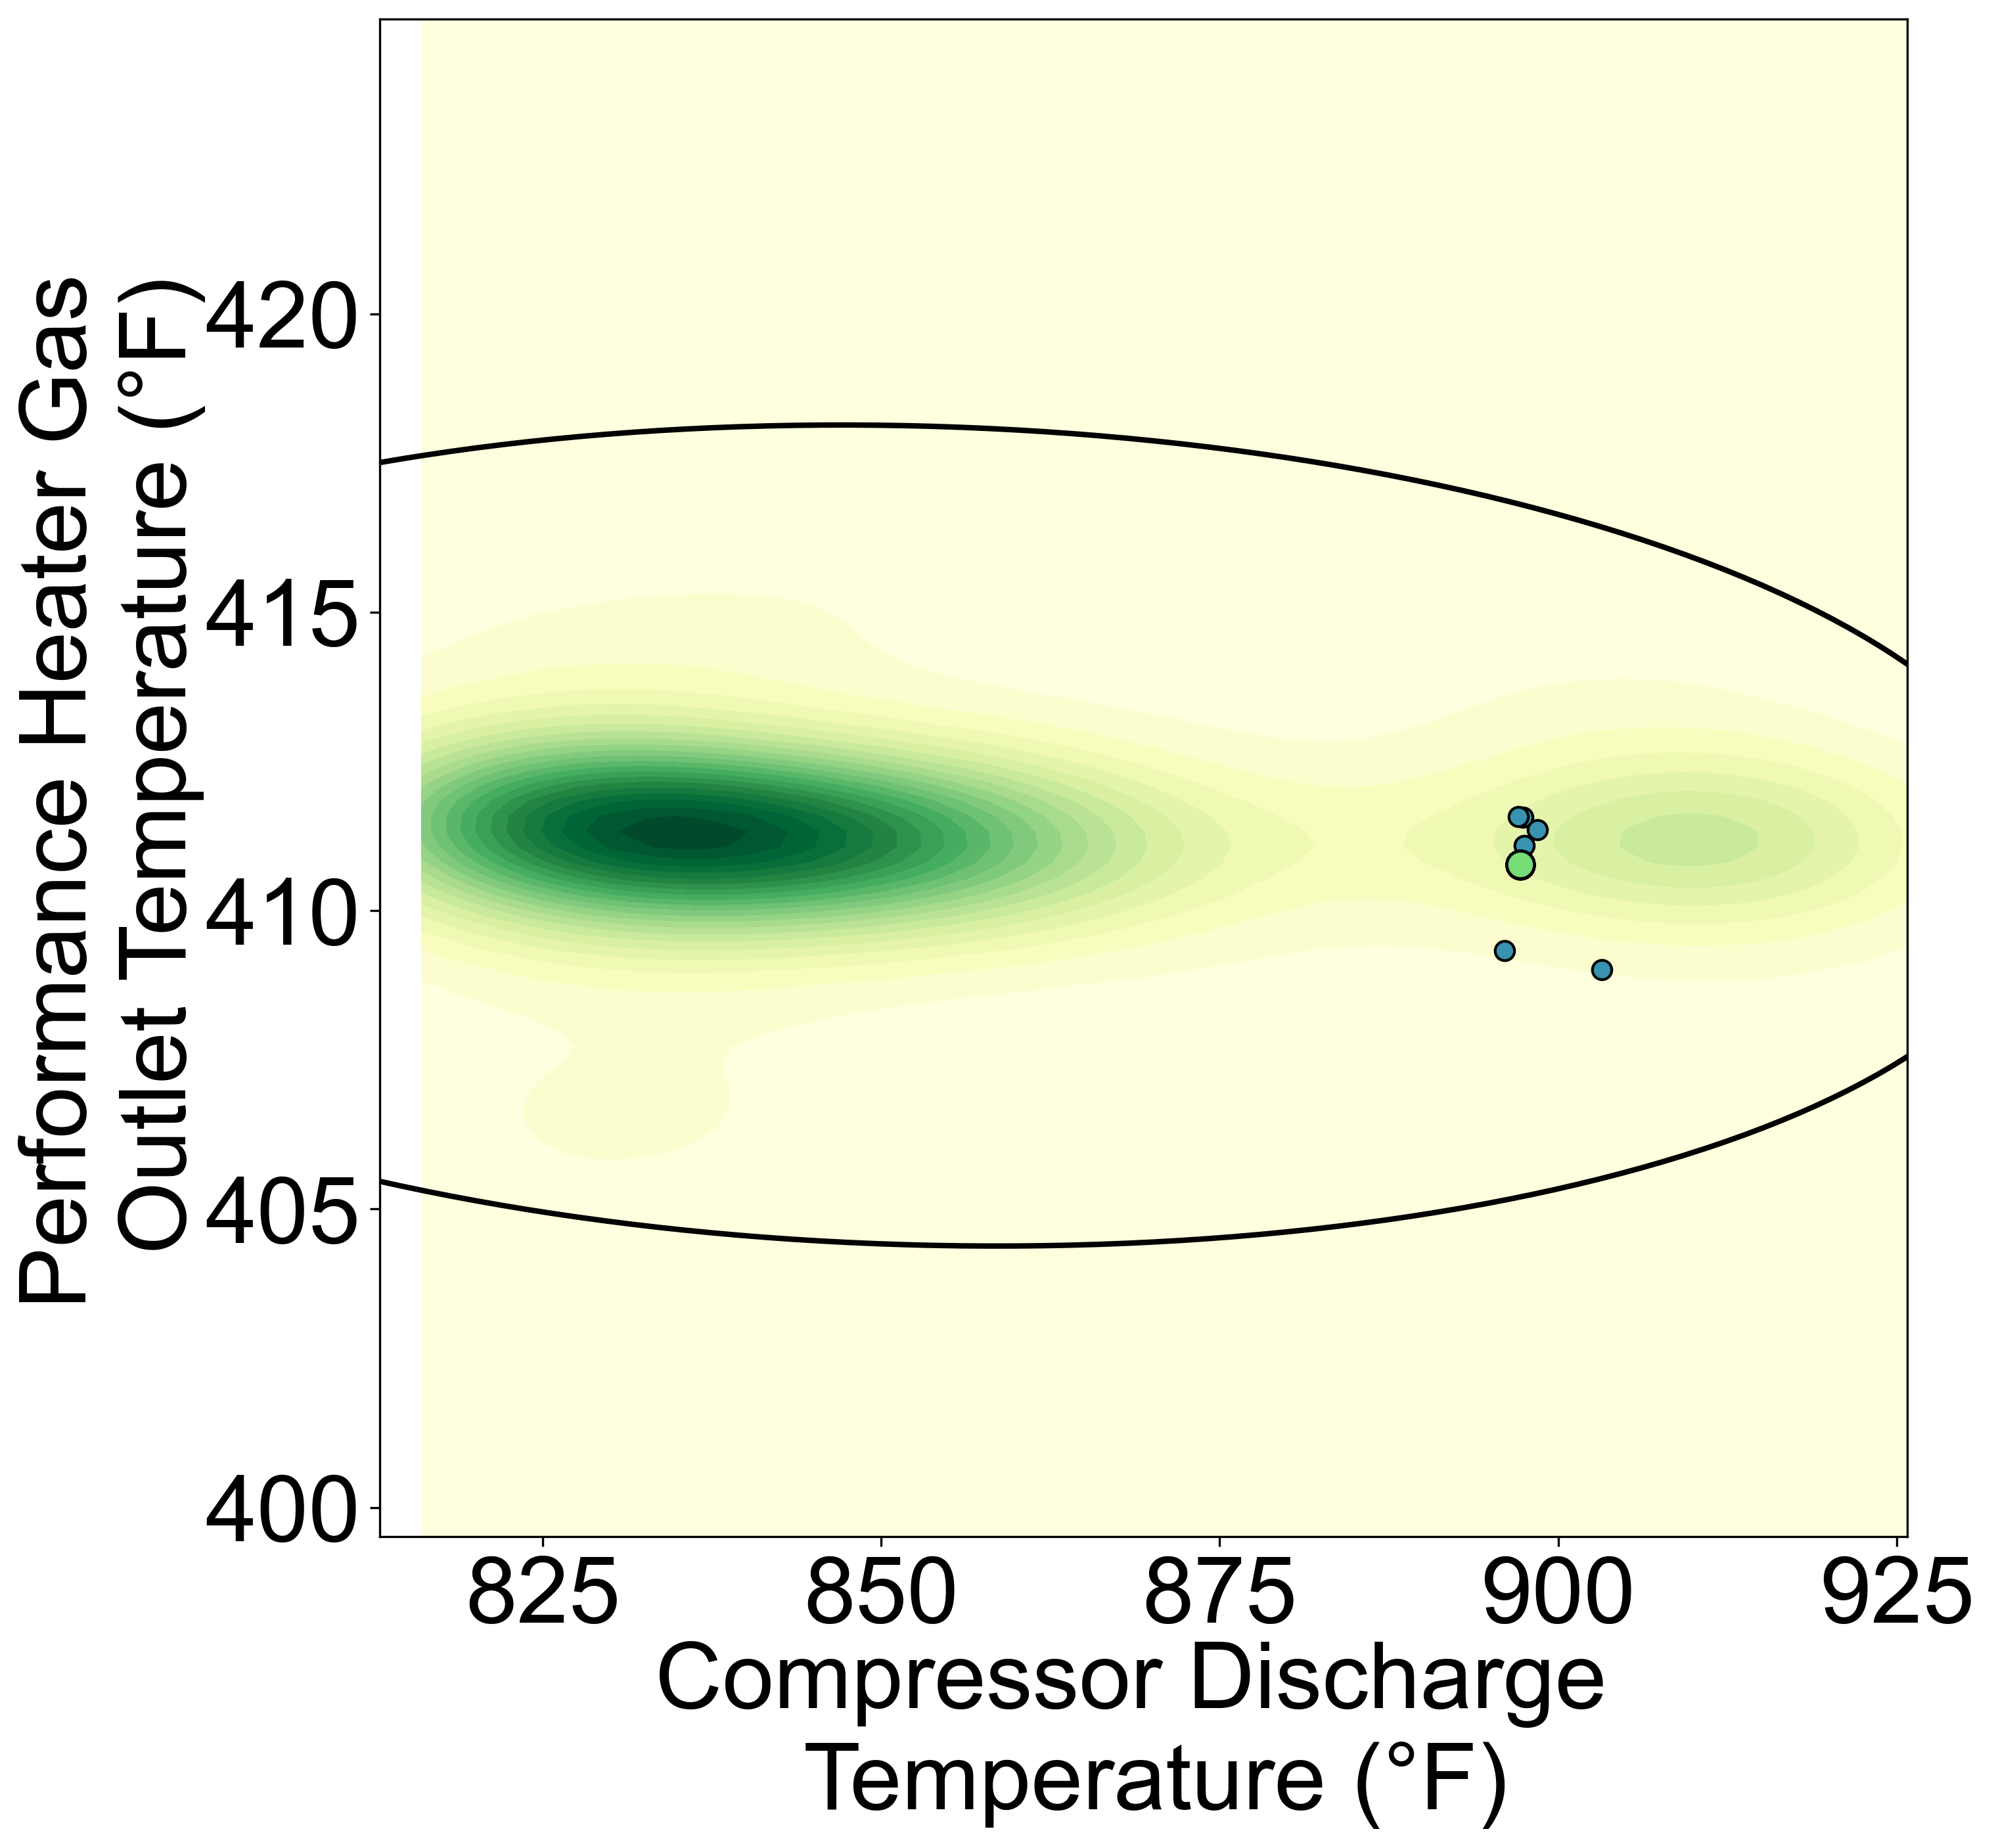

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# -------------------------------
# Configuration variables
# -------------------------------
feature_x = 'cdt'
feature_y = 'phgot'
color_map = 'YlGn'  # Light, visually pleasant color map
grid_resolution = 100
num_intermediate_points = 50  # Number of points along the convergence path
fig_size = (10, 10)
fig_dpi = 300
tolerance = 0.95  # 95% coverage ellipse
ellipse_style = {'edgecolor': 'black', 'linestyle': '-', 
                'linewidth': 2, 'facecolor': 'None','alpha' :1}
# -------------------------------

# Set global font properties
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 18,
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})

# Extract data from DataFrame
data = df[[feature_x, feature_y]].values

# Calculate statistics
mu = np.mean(data, axis=0)
cov = np.cov(data, rowvar=False)
inv_cov = np.linalg.inv(cov)

# Calculate Mahalanobis distances
centered_data = data - mu
D_M = np.sqrt(np.einsum('...i,ij,...j->...', centered_data, inv_cov, centered_data))
delta = np.percentile(D_M, tolerance * 100)

# Calculate ellipse parameters
eigenvals, eigenvecs = np.linalg.eigh(cov)
order = eigenvals.argsort()[::-1]
eigenvals, eigenvecs = eigenvals[order], eigenvecs[:, order]
angle = np.degrees(np.arctan2(*eigenvecs[:, 0][::-1]))
width, height = 2 * delta * np.sqrt(eigenvals)


x = df[feature_x]
y = df[feature_y]

# Perform Kernel Density Estimation (KDE) to estimate density distribution
kde = gaussian_kde([x, y])

# Create a high-resolution grid for evaluating the KDE
xlist = np.linspace(x.min(), x.max(), grid_resolution)
ylist = np.linspace(y.min(), y.max(), grid_resolution)
X, Y = np.meshgrid(xlist, ylist)

# Evaluate the KDE on the grid
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kde(positions).T, X.shape)
# Create plot
fig, ax = plt.subplots(figsize=fig_size, dpi=fig_dpi)
cb = ax.contourf(X, Y, Z, levels=25, cmap=color_map)

# Add Mahalanobis ellipse
ax.add_patch(Ellipse(mu, width, height, angle=angle, **ellipse_style))

ax.scatter(
    extra[(extra['power'] < current_value + 1) & (extra['power'] > current_value - 1)][feature_x],
    extra[(extra['power'] < current_value + 1) & (extra['power'] > current_value - 1)][feature_y], 
    color="#3793AF", edgecolor='black', s=50, label='Experimental'
)
ax.scatter(best_values[feature_x], best_values[feature_y], 
           color='#77DD77', edgecolor='black', s=100, label='Solution')


# Configure axes and legend
ax.set_xlabel('Compressor Discharge \n Temperature (°F)', labelpad=0, fontsize=34)
ax.set_ylabel('Performance Heater Gas \n Outlet Temperature (°F)', labelpad=0, fontsize=34)
ax.tick_params(axis='both', which='major', labelsize=34)  # Increase tick font size
#ax.legend(loc='upper left')

all_x = np.concatenate([df[feature_x], 
                       val_1[feature_x], 
                       best_values[feature_x]])
all_y = np.concatenate([df[feature_y], 
                       val_1[feature_y], 
                       best_values[feature_y]])


plt.xlim(all_x.min(), all_x.max())
plt.ylim(all_y.min(), all_y.max())
plt.savefig(f'non_correlated_{current_value}_{tolerance}.png',bbox_inches='tight', pad_inches=0.3)
plt.show()

# Ramp up

In [ ]:
import pandas as pd

input_labels = ['cdp', 'gffr', 'fgt', 'at', 'ap', 'ah', 'phgot', 'cdt', 'fgext']
results_all = []
power_range =range(185, 395, 15)  # Range of power setpoints from 185 to 395 with step of 20  

for power_setpoint in power_range:
    scaled_power = scaler_input1.transform([[power_setpoint]])[0][0]

    def power_constraint(model): 
        return (power(model) - scaled_power)**2 == 1e-10

    model.power_constraint = Constraint(rule=power_constraint)
    best_objective = float('inf')  # for minimization
    best_solution = {}

    best_values = []
    thr_sol = []
    power_sol = []
    TE_sol = []

    for x0 in vals[:50]:  
        initial_values = list(np.clip(x0, 0, 1))
        for i in range(x0.shape[0]):
            model.x[i] = initial_values[i]

        results = solver.solve(model, tee=False)

        optimal_scaled = [model.x[i]() for i in range(x0.shape[0])]
        optimal_real = scaler_input.inverse_transform([optimal_scaled])[0]
        scaled_value_power = power(model)()
        original_value_power = scaler_input1.inverse_transform([[scaled_value_power]])[0][0]
        scaled_value_thr = thr(model)()
        original_value_thr = scaler_input2.inverse_transform([[scaled_value_thr]])[0][0]
        scaled_value_te = te(model)()
        original_value_te = scaler_input3.inverse_transform([[scaled_value_te]])[0][0]

        # Objective value (same logic as used in Pyomo)
        objective_val = original_value_thr - original_value_te

        # ✅ Convert to dict here
        if objective_val < best_objective:
            best_objective = objective_val
            best_solution = {
                "Objective Value": best_objective,
                "Power Setpoint": power_setpoint,
                "Power": original_value_power,
                "THR": original_value_thr,
                "TE": original_value_te,
                **dict(zip(input_labels, optimal_real))
            }
    results_all.append(best_solution)
df_best = pd.DataFrame(results_all)
df_best.to_csv("mean_cond_best_local_solutions.csv", index=False)

# Uncertainty Assessment

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Number of Monte Carlo runs
n_runs = 1000

# Choose which row (solution) to analyze, e.g., the first one
row = optimal_real

# Extract optimal input values
input_labels = ['cdp', 'gffr', 'fgt', 'at', 'ap', 'ah', 'phgot', 'cdt', 'fgext']
optimal_inputs = optimal_inputs = np.array(row).astype(float)

# Define standard deviations for each input (adjust as needed)
input_stds = np.array([0.442,	0.068,	0.179,	0.044,	0.024,	0.170,	0.030,	0.411,	0.191])  # Example stds

# Storage for outputs
outputs = []

for i in range(n_runs):
    # Perturb inputs with Gaussian noise
    perturbed_inputs = optimal_inputs + np.random.normal(0, input_stds, size=optimal_inputs.shape)
    
  
    
    # Prepare DataFrame for scaling
    perturbed_df = pd.DataFrame([perturbed_inputs], columns=input_labels)
    perturbed_scaled = scaler_input.transform(perturbed_df)

    # Optionally, clip to physical bounds
    perturbed_inputs = np.clip(perturbed_scaled, lower_bounds, upper_bounds)
    
    # Set model variables
    for j, label in enumerate(input_labels):
        model.x[j] = perturbed_scaled[0, j]
    
    # Evaluate outputs
    thr_val = thr(model)()
    power_val = power(model)()
    te_val = te(model)()
    
    # Inverse transform outputs if needed
    thr_real = scaler_input2.inverse_transform([[thr_val]])[0][0]
    power_real = scaler_input1.inverse_transform([[power_val]])[0][0]
    te_real = scaler_input3.inverse_transform([[te_val]])[0][0]
    
    outputs.append([thr_real, power_real, te_real])

outputs = np.array(outputs)
thr_vals, power_vals, te_vals = outputs[:,0], outputs[:,1], outputs[:,2]

# Plot histograms of outputs
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(thr_vals, bins=30, color='skyblue')
plt.axvline(x=original_value_thr, color='black', linestyle='--', linewidth=1.5, label='Optimal')
plt.xlabel('Turbine Heat Rate (kJ/kWh)')
plt.ylabel('Frequency')

plt.subplot(1,3,2)
plt.hist(power_vals, bins=30, color='lightgreen')
plt.axvline(x=original_value_power, color='black', linestyle='--', linewidth=1.5, label='Optimal')
plt.xlabel('Power (MW)')

plt.subplot(1,3,3)
plt.hist(te_vals, bins=30, color='salmon')
plt.axvline(x=original_value_te, color='black', linestyle='--', linewidth=1.5, label='Optimal')
plt.xlabel('Thermal Efficiency (%)')
plt.tight_layout()
plt.savefig('{390}Local_sensitivity_analysis_histograms.png', dpi=300)
plt.show()

In [ ]:
thr_mean = outputs[:,0].mean()
power_mean = outputs[:,1].mean()
te_mean = outputs[:,2].mean()

thr_std = outputs[:,0].std()
power_std = outputs[:,1].std()
te_std = outputs[:,2].std()

thr_ci = np.percentile(outputs[:,0], 97.5) - np.percentile(outputs[:,0], 2.5)
power_ci = np.percentile(outputs[:,1], 97.5) - np.percentile(outputs[:,1], 2.5)
te_ci = np.percentile(outputs[:,2], 97.5) - np.percentile(outputs[:,2], 2.5)

print(f"Mean THR: {thr_mean:.2f} | Mean Power: {power_mean:.2f} | Mean TE: {te_mean:.2f}")
print(f"Std THR: {thr_std:.2f} | Std Power: {power_std:.2f} | Std TE: {te_std:.2f}")
print(f"95% CI width THR: {thr_ci:.2f} | Power: {power_ci:.2f} | TE: {te_ci:.2f}")